# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Exploration of Data


## 1. Portfolio Dataframe

In [4]:
import pandas as pd
import numpy as np
import math
import json
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import classification_report
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


## 2. Profile Dataframe

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Checking null values in profile dataframe

In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
profile[profile['gender'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [12]:
len(profile[profile['gender'].isnull()]['income'])

2175

All missing gender, income values have age 18

## 3. Transcript Dataframe

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [15]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [16]:
len(transcript['person'].unique())

17000

In [17]:
len(transcript['event'].unique())

4

# Cleaning Data

## 1. Portfolio Dataframe

* Covertinng channels column into dummy columns
* Renaming id to offer_id

In [18]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [19]:
dfpo = portfolio.copy()
dummy = pd.get_dummies(dfpo.channels.apply(pd.Series).stack()).sum(level=0)
dfpo = pd.concat([dfpo, dummy], axis=1)
dfpo = dfpo.drop(columns='channels')

In [20]:
dfpo = dfpo.rename(columns={'id':'offer_id'})

## 2. Profile Dataframe

* Imputed null values in age, gender, income values with mean/mode
* Changed format of became_member_on column

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
dfpr = profile.copy()
dfpr['income'] = dfpr['income'].fillna(dfpr['income'].mean())
dfpr['age'] = dfpr['age'].fillna(dfpr['age'].mean())
dfpr['gender'] = dfpr['gender'].fillna(dfpr['gender'].mode()[0])
dfpr['became_member_on'] = pd.to_datetime(dfpr['became_member_on'], format='%Y%m%d')
dfpr = dfpr.rename(columns={'id':'user_id'})

## 3. Transcript Dataframe

* Renaming person to user_id
* Making dummy columns for event column
* Changed value column to 2 columns based on whether it had offer id or amount

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
dftr = transcript.copy()

In [25]:
dftr = dftr.rename(columns={'person':'user_id'})

In [26]:
dummy = pd.get_dummies(dftr['event'])
dftr = pd.concat([dftr, dummy], axis=1 )


In [27]:
dftr['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id', 'offer_id'] else None for i in dftr.value] 
dftr['amount'] = [[*i.values()][0] if [*i.keys()][0] in ['amount'] else None for i in dftr.value] 

In [28]:
dftr.head()

,event,user_id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [29]:
dftr = dftr.drop('event', axis =1)

In [30]:
dftr.head()

,user_id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Merging the 3 datasets

In [31]:
df_merged = pd.merge(dfpo, dftr, on='offer_id', how = 'left')
df_merged = pd.merge(df_merged, dfpr, on='user_id', how = 'left')

In [32]:
df_merged.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,user_id,...,value,offer completed,offer received,offer viewed,transaction,amount,age,became_member_on,gender,income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,64,2017-09-09,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1e9420836d554513ab90eba98552d0a9,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,22,2017-09-25,M,70000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,02c083884c7d45b39cc68e1314fec56c,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,20,2016-07-11,F,30000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,676506bad68e4161b9bbaffeb039626b,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,37,2017-05-15,M,92000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,fe8264108d5b4f198453bbb1fa7ca6c9,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,78,2016-10-09,F,93000.0


In [33]:
df_merged = df_merged.drop('transaction', axis=1)
df_merged.describe()


,difficulty,duration,reward,email,mobile,social,web,time,offer completed,offer received,offer viewed,amount,age,income
count,167581.000000,167581.000000,167581.00000,167581.0,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,0.0,167581.000000,167581.000000
mean,7.850401,6.610737,4.41991,1.0,0.917944,0.656996,0.806858,353.778412,0.200375,0.455165,0.344460,NaN,61.862616,66301.055142
std,5.048944,2.136130,3.37336,0.0,0.274451,0.474714,0.394765,198.301287,0.400282,0.497987,0.475193,NaN,25.693155,20259.401992
min,0.000000,3.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000,30000.000000
25%,5.000000,5.000000,2.00000,1.0,1.000000,0.000000,1.000000,168.000000,0.000000,0.000000,0.000000,NaN,45.000000,52000.000000
50%,10.000000,7.000000,5.00000,1.0,1.000000,1.000000,1.000000,408.000000,0.000000,0.000000,0.000000,NaN,58.000000,65404.991568
75%,10.000000,7.000000,5.00000,1.0,1.000000,1.000000,1.000000,510.000000,0.000000,1.000000,1.000000,NaN,72.000000,78000.000000
max,20.000000,10.000000,10.00000,1.0,1.000000,1.000000,1.000000,714.000000,1.000000,1.000000,1.000000,NaN,118.000000,120000.000000


# Data Vizualization & Observations

In [34]:
df_merged.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,user_id,time,value,offer completed,offer received,offer viewed,amount,age,became_member_on,gender,income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,NaN,64,2017-09-09,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1e9420836d554513ab90eba98552d0a9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,NaN,22,2017-09-25,M,70000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,NaN,20,2016-07-11,F,30000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,676506bad68e4161b9bbaffeb039626b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,NaN,37,2017-05-15,M,92000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,fe8264108d5b4f198453bbb1fa7ca6c9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,NaN,78,2016-10-09,F,93000.0


### Most Sent Offer 

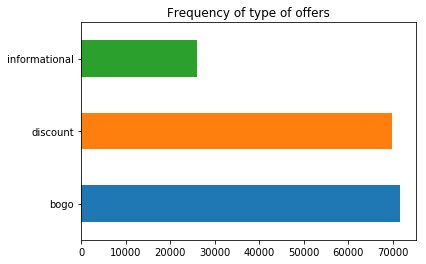

In [35]:
df_merged['offer_type'].value_counts().plot.barh(title='Frequency of type of offers')

BOGO & Discount are the offers which are sent out on a much more regular bases than informational offers

### Gender Distribution

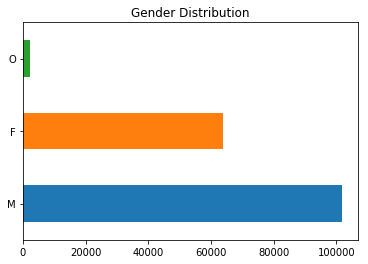

In [36]:
df_merged['gender'].value_counts().plot.barh(title='Gender Distribution')

Males dominate the gender distribution

### Salary Distribution

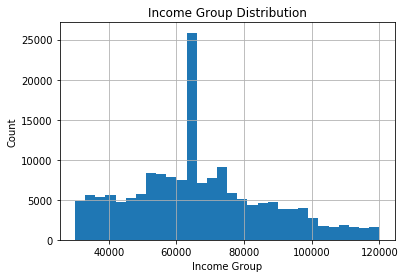

In [37]:
df_merged.income.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

Most people are middle class with income about 70000

### Proportion of viewed & completed offers

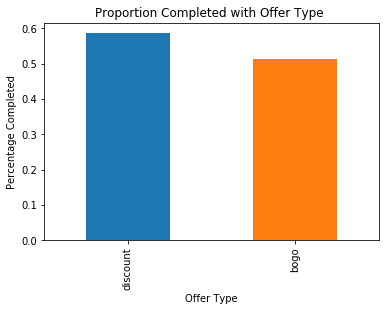

In [38]:
offer_received = df_merged[df_merged['offer received'] == 1].offer_type.value_counts()[0:2]
offer_completed = df_merged[df_merged['offer completed'] == 1].offer_type.value_counts()[0:2]
proportion = offer_completed/offer_received
proportion.plot(kind='bar')
plt.ylabel('Percentage Completed')
plt.xlabel('Offer Type')
plt.title('Proportion Completed with Offer Type ');

<b> Observation: Around 60% people who received discount offer went on to complete it and for BOGO around 50% completed it </b>

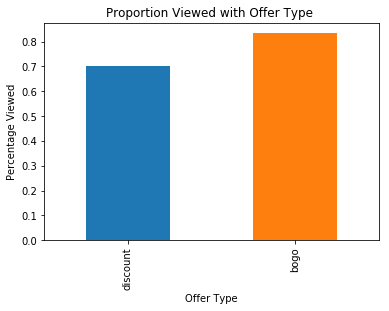

In [39]:
offer_received = df_merged[df_merged['offer received'] == 1].offer_type.value_counts()[0:2]
offer_viewed = list(reversed(df_merged[df_merged['offer viewed'] == 1].offer_type.value_counts()[0:2]))
proportion = offer_viewed/offer_received
proportion.plot(kind='bar')
plt.ylabel('Percentage Viewed')
plt.xlabel('Offer Type')
plt.title('Proportion Viewed with Offer Type ');

<b> More than 80% who received the BOGO offer viewed it and around 70% who received the discount offer viewed it </b>

# Modelling

## Some Additional Cleaning

In [40]:
df_merged[df_merged['offer_type'] == 'bogo']['offer_id'].describe()

count                                71617
unique                                   4
top       f19421c1d4aa40978ebb69ca19b0e20d
freq                                 19131
Name: offer_id, dtype: object

Converting categorical columns to numerical

In [41]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
df_merged['offer_type'] = df_merged['offer_type'].map(offers)

In [42]:
genders = {'O': 0, 'M': 1, 'F': 2}
df_merged['gender'] = df_merged['gender'].map(genders)
df_merged['amount'] = df_merged['amount'].fillna(0)

In [43]:
df_merged = df_merged.sample(frac=1).sort_values(by = ['time'])
df_merged.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,user_id,time,value,offer completed,offer received,offer viewed,amount,age,became_member_on,gender,income
64773,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,5,1,0,0,1,3c65635c6c984c3280fcfc39382452dd,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0.0,74,2017-03-07,1,77000.000000
48381,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,1,1,0,1,8214a0d3138c47ee8397379d15178fd3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0.0,40,2015-09-02,1,54000.000000
133724,5,5,f19421c1d4aa40978ebb69ca19b0e20d,0,5,1,1,1,1,d1cccfb974bc461c9d99d89fb2d9fe52,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1,0,0.0,118,2016-03-10,1,65404.991568
133899,5,5,f19421c1d4aa40978ebb69ca19b0e20d,0,5,1,1,1,1,cae9515311754366aacb3044f0971484,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1,0,0.0,63,2014-06-09,1,47000.000000
18276,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,1,1,1,1,cd15d81298054b478592e89a093bba18,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0.0,118,2015-09-26,1,65404.991568


## Preparing Data For FunkSVD

In [44]:
def create_user_item_matrix(filename, df):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = df.groupby(['user_id', 'offer_id'])['offer_type'].apply(lambda x: np.nan).unstack()
    print(user_item_matrix.shape)
    # we just focus on bogo and discount first
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        for user in user_item_matrix.index:
            events = []
            for event in df[(df['offer_id']==offer_id) & (df['user_id']==user)][['offer received', 'offer viewed', 'offer completed']].values:
                events.extend(event)
            if len(events) >= 9:
                user_item_matrix.loc[user, offer_id] = 0
                for i in range(int(len(events)/3) - 2):

                    if (events[3*i] == 1) & (events[3*(i+1)+1] == 1) & (events[3*(i+2)+2] == 1):
                        user_item_matrix.loc[user, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[user, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [45]:
train_offer = df_merged[:int(df_merged.shape[0]*0.7)]
test_offer = df_merged[int(df_merged.shape[0]*0.7):]


In [169]:
test_matrix = create_user_item_matrix('test_matrix.p', test_offer)


(15815, 10)
Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Now processing:  2906b810c7d4411798c6938adc9daaa5
Now processing:  3f207df678b143eea3cee63160fa8bed
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Now processing:  5a8bc65990b245e5a138643cd4eb9837
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
Now processing:  fafdcd668e3743c1bb461111dcafc2a4


In [43]:
user_item_matrix = pd.read_pickle('user_item_matrix.p')
train_matrix = pd.read_pickle('train_matrix.p')
test_matrix = pd.read_pickle('test_matrix.p')


In [44]:
user_item_matrix.describe()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
count,6374.000000,6325.000000,6285.000000,6331.0,6330.000000,6320.0,6355.000000,6374.000000,6262.000000,6332.000000
mean,0.185598,0.552411,0.282896,0.0,0.331122,0.0,0.278049,0.332758,0.427978,0.588282
std,0.414971,0.587649,0.489386,0.0,0.524027,0.0,0.486469,0.530155,0.565050,0.597162
min,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,3.000000,3.000000,3.000000,0.0,4.000000,0.0,3.000000,3.000000,3.000000,3.000000


## Load Test & Train Data

In [46]:
user_item_matrix = pd.read_pickle('user_item_matrix.p')
train_matrix = pd.read_pickle('train_matrix.p')
test_matrix = pd.read_pickle('test_matrix.p')

In [47]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_latent_mat = np.random.rand(n_users, latent_features)
    offer_latent_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_total = 0
    
    # keep track of iteration and MSE
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        
        # update our sse
        old_sse = sse_total
        sse_total = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_latent_mat[i, :], offer_latent_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_total += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_latent_mat[i, k] += learning_rate * (2*diff*offer_latent_mat[k, j])
                        offer_latent_mat[k, j] += learning_rate * (2*diff*user_latent_mat[i, k])

        # print results
       # print("%d \t\t %f" % (iteration+1, sse_total / num_complete))
        
    return user_latent_mat, offer_latent_mat

In [48]:
train_matrix_np = np.array(train_matrix)

In [49]:
def predict_reaction(user_latent_matrix, offer_latent_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids = np.array(train_matrix.index)
        offer_ids = np.array(train_matrix.columns)

        # User row and Movie Column
        user_row = np.where(user_ids == user_id)[0][0]
        offer_col = np.where(offer_ids == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_latent_matrix[user_row, :], offer_latent_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [50]:
def validation(test_matrix, user_latent_mat, offer_latent_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_matrix))
    
    sse_total = 0
    
    for user_id in test_matrix.index:
        for offer_id in test_matrix.columns:
            if ~np.isnan(test_matrix.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_latent_mat, offer_latent_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_matrix.loc[user_id, offer_id] - predict_reaction(user_latent_mat, offer_latent_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_total += diff**2
    
    print(sse_total / num_complete)
    return sse_total / num_complete

In [51]:
def validationplot(j,k):
    a = []
    for m in range(k):
        b = [50*(i+1) for i in range(j)]
        for i in range(j):
            user_latent_mat, offer_latent_mat = FunkSVD(train_matrix_np, latent_features=5*(m+1), learning_rate=0.005, iters=50*(i+1))
            a.append(validation(test_matrix, user_latent_mat, offer_latent_mat))
        
        
        print(b)
        print(a)
        plt.plot(b,a)   
        a=[]
        b=[]
        
    plt.legend(["5", "10", "15"])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    plt.title('Iterations vs Error for latent features');

Optimizaiton Statistics
Iterations | Mean Squared Error 
0.148870128447
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.148578975216
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.146950130973
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.152085065032
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.153947063241
[10, 20, 30, 40, 50]
[0.14887012844713549, 0.14857897521647767, 0.14695013097315721, 0.15208506503182631, 0.15394706324086613]
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.150702175475
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.148945247124
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.153963540309
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.153167169022
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.153858726306
[10, 20, 30, 40, 50]
[0.15070217547484382, 0.14894524712430943, 0.15396354030882775, 0.15316716902168423, 0.15385872630609676]
Optimizaiton Statistics
It

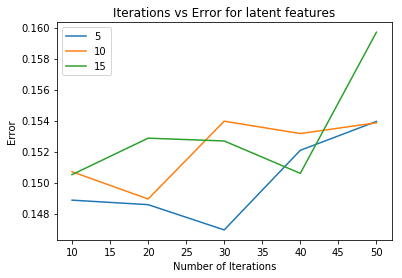

In [58]:
validationplot(5,3)


Optimizaiton Statistics
Iterations | Mean Squared Error 
0.153114885827
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.179564791282
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.213317781085
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.239272400198
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.25756493687
[50, 100, 150, 200, 250]
[0.15311488582697327, 0.17956479128162525, 0.21331778108516375, 0.23927240019846924, 0.25756493687019599]
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.155891038271
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.202546345732
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.243182452221
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.267344008796
Optimizaiton Statistics
Iterations | Mean Squared Error 
0.276634568284
[50, 100, 150, 200, 250]
[0.15589103827088077, 0.20254634573176589, 0.24318245222133505, 0.26734400879602199, 0.27663456828361205]
Optimizaiton Statis

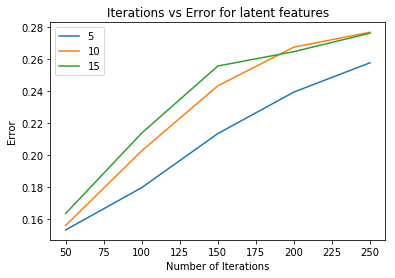

In [116]:
validationplot(5,3)

In [150]:
user_latent_mat, offer_latent_mat = FunkSVD(train_matrix_np, latent_features=5, learning_rate=0.005, iters=50)


Optimization Statistics
Iterations | Mean Squared Error 


In [114]:
validation(test_matrix, user_latent_mat, offer_latent_mat)

0.150052403765


0.15005240376455375

In [146]:
def top_offer(user_item_matrix):
    temp = user_item_matrix.copy()
    a = []
    for offer_id in user_item_matrix.columns:
        a.append([user_item_matrix[offer_id].mean(), offer_id])
    b = pd.DataFrame(a, columns = ['completed_sum', 'offer_id'])    
    b.sort_values(by='completed_sum', ascending=False, inplace=True)
    return b
    

In [147]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in user_item_matrix.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offers = top_offer(user_item_matrix)
        for offer_id in top_offers['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [151]:
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_latent_mat, offer_latent_mat)


recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.53
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.49
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.24
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.23
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.23
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.22
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.18
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.14
offer id:  5a8bc65990b245e5a138643cd4eb9837  predicted value:  0.0
offer id:  3f207df678b143eea3cee63160fa8bed  predicted value:  -0.0


In [152]:
recommend_offer('new_user', user_latent_mat, offer_latent_mat)


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7
offer id:  3f207df678b143eea3cee63160fa8bed
offer id:  5a8bc65990b245e5a138643cd4eb9837


# Analysis